In [2]:
#!pip3 install torchvision==0.12.0
#!pip3 install torch==1.11.0
#!pip3 install torchtext==0.12.0
#!python3 -m spacy download en_core_web_sm

In [3]:
import torch.nn as nn
import torchvision.models as models
import torch

import os
import pandas
import spacy
import torchtext

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

# python3 -m spacy download en_core_web_sm

print(torch.__version__, torchtext.__version__, spacy.__version__)

spacy_eng = spacy.load("en_core_web_sm")


1.11.0 0.12.0 3.3.1


In [4]:

class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
        
annotation = pandas.read_csv("./flickr8k/captions.txt")


In [5]:

class FlickrDataset(Dataset):
    def __init__(self, root_dir="./flickr8k/images", caption_path="./flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets


transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

def get_loader(root_dir="./flickr8k/images", caption_path="./flickr8k/captions.txt", transform=transform, batch_size=32, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset



In [6]:

loader, dataset = get_loader()



10000


In [7]:
for image, text in loader:
    print(image.shape, text.shape)
    break

torch.Size([32, 3, 299, 299]) torch.Size([23, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108926, 108663, 108917, 108664, 108889, 108926, 108830, 106927,
        108925,      2])


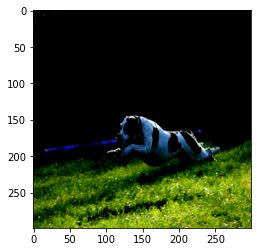

In [8]:

import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape


import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])


In [9]:

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")


def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

from tqdm import tqdm

torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model = False
train_CNN = False

<SOS> a dog is running through a green yard . <EOS> 

In [10]:
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [11]:
new_model = models.inception_v3(pretrained=True, aux_logits=False)
new_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [12]:
class encoder(nn.Module):
    def __init__(self, emb_size):
        super(encoder, self).__init__()
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, emb_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = self.inception(x)

        # should not do backpropagation and update the model weights
        for name, param in self.inception.named_parameters():
            param.requires_grad = False

        print(features.shape) # batch x emb_size
        return features

In [14]:
class decoder(nn.Module):
    def __init__(self, emb_size, vocab_size, hid_size, num_layers):
        super(decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, num_layers = num_layers, bidirectional = False)
        self.linear = nn.Linear(hid_size, vocab_size)
        
    def forward(self, features, caption):
        embedded_caption = self.embedding(caption)

        # features = 1 x batch x emb_size 
        # embedded_caption = seq_len x batch x emb_size 
        print(features.shape, embedded_caption.shape)
        embedded_image_and_caption = torch.cat((features.unsqueeze(0), embedded_caption), dim=0)

        # lstm_out = (seq_len + 1) x batch x hidden_size 
        print(embedded_image_and_caption.shape)
        lstm_out, _ = self.lstm(embedded_image_and_caption)

        # outputs = (seq_len + 1) x batch x vocab_size 
        outputs = self.linear(lstm_out)

        print(outputs)
        return outputs 

In [15]:
class seq2seq(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(seq2seq, self).__init__()
        self.encoder = encoder(embed_size)
        self.decoder = decoder(embed_size, vocab_size, hidden_size, num_layers)

    def forward(self, images, caption):
        x = self.encoder(images)
        x = self.decoder(x, caption)
        return x 
        

In [16]:
model = seq2seq(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [17]:
model.decoder

decoder(
  (embedding): Embedding(108931, 256)
  (lstm): LSTM(256, 256, num_layers=5)
  (linear): Linear(in_features=256, out_features=108931, bias=True)
)

In [18]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [19]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [23]:
model.train()

for epoch in range(1):

    for idx, (imgs, captions) in enumerate(loader):
          
        optimizer.zero_grad()

        imgs = imgs.to(device)
        captions = captions.to(device)
        
        print(imgs.shape, captions.shape)

        score = model(imgs, captions[:-1])

        print("score: ", score.shape, score.type(), "captions: ", captions.shape, captions.type())

        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
        step += 1
        
        loss.backward()
        optimizer.step()
        break
        
    print(f"Loss for epoch {epoch}: {loss}")

torch.Size([32, 3, 299, 299]) torch.Size([24, 32])
torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([23, 32, 256])
torch.Size([24, 32, 256])
tensor([[[-0.0271,  0.0668,  0.0942,  ...,  0.0340,  0.0337, -0.0137],
         [-0.0293,  0.0690,  0.0995,  ...,  0.0359,  0.0367, -0.0132],
         [-0.0265,  0.0662,  0.0928,  ...,  0.0335,  0.0329, -0.0138],
         ...,
         [-0.0262,  0.0659,  0.0921,  ...,  0.0332,  0.0325, -0.0139],
         [-0.0258,  0.0655,  0.0911,  ...,  0.0328,  0.0319, -0.0139],
         [-0.0236,  0.0632,  0.0856,  ...,  0.0309,  0.0289, -0.0144]],

        [[-0.2947,  0.3493,  0.7143,  ...,  0.2630,  0.3814,  0.0576],
         [-0.3110,  0.3663,  0.7528,  ...,  0.2778,  0.4026,  0.0619],
         [-0.2904,  0.3447,  0.7039,  ...,  0.2589,  0.3758,  0.0565],
         ...,
         [-0.2877,  0.3421,  0.6978,  ...,  0.2566,  0.3724,  0.0558],
         [-0.2850,  0.3392,  0.6913,  ...,  0.2541,  0.3688,  0.0551],
         [-0.2668,  0.3202,  0.6482,  ...,